# Model stacking experiments on Histologic images

This notebook incorporates two techniques to enhance the performance of the deep networks (ResNet and VGG16 used here) - 
* Model stacking (Multi-class logistic regression is used in this case)
* Transfer learning aided with fine-tuning of layers

In [74]:
import pandas as pd
import numpy as np
import random
from scipy.misc import imresize
from scipy.misc import imshow
from scipy.misc import imread
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

# For fixing the randomness and thereby enabling my team members to reproduce the experiments
np.random.seed(7)

import warnings
warnings.filterwarnings("ignore")

## Load pretrained models: ResNet, VGG16

In [2]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.



## Prepare the data and splitting

In [5]:
filename_csv = pd.read_csv('data_chec_resized/dat.csv', sep=',')
temp = []
for img_name in filename_csv.filename:
    img_path = os.path.join('data_chec_resized', 'pool', img_name)
    img = imread(img_path)
    img = imresize(img, (256,192))
    #img = img.astype('float32') 
    temp.append(img)

X = np.stack(temp)

In [6]:
import keras
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

y = lb.fit_transform(filename_csv['label'])
y = keras.utils.np_utils.to_categorical(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## ResNet50

For ResNet50, we will take predictions from this pretrained model and feed that as input to a simple Logistic Regression model. Thanks to Anirudh for incorporating this. 

In [8]:
resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(256, 192, 3))

Instructions for updating:
Colocations handled automatically by placer.
94658560/94653016 [==============================] - 48s 1us/step


In [17]:
# Use the model to predict and store the results
train_feats=resnet.predict(X_train)
print(train_feats.shape)

(64, 8, 6, 2048)


In [18]:
# Flatten the output vector
train_features = np.reshape(train_feats, (X_train.shape[0], 8 * 6 * 2048))
train_features.shape

(64, 98304)

## Using the ResNet model outputs to further train a multi-class Logisitic Regression model

In [19]:
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import ClassifierChain

logreg = LogisticRegression()
multi_label_logreg = ClassifierChain(logreg)
multi_label_logreg.fit(train_features, y_train)

ClassifierChain(classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        order=None, require_dense=[True, True])

In [21]:
test_feats = resnet.predict(X_test)
print(test_feats.shape)

(16, 8, 6, 2048)


## Evaluate the final model and log accuracy score, classification_report

In [23]:
test_feats = np.reshape(test_feats, (X_test.shape[0], 8 * 6 * 2048))
predictions = multi_label_logreg.predict(test_feats)

print(accuracy_score(y_test,predictions) * 100.)

62.5


In [47]:
print(classification_report(y_test, predictions, target_names = filename_csv.label.unique()))

              precision    recall  f1-score   support

          SI       0.67      0.50      0.57         4
        Skin       0.00      0.00      0.00         0
      Kidney       1.00      0.50      0.67         2
     Bladder       0.00      0.00      0.00         0
        Lung       1.00      1.00      1.00         3
       Brain       1.00      0.50      0.67         2
       Liver       1.00      0.67      0.80         3
          LI       1.00      0.50      0.67         2

   micro avg       0.91      0.62      0.74        16
   macro avg       0.71      0.46      0.55        16
weighted avg       0.92      0.62      0.73        16
 samples avg       0.62      0.62      0.62        16



## VGG16 + A bit of modifications

For VGG16, will only add another Pooling layer, a BatchNorm layer followed by three fully connected layers. This is also known as **fine-tuning**. 

In [25]:
base_model = VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(256, 192, 3))

In [26]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [27]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(8, activation='softmax')(x)
model = Model(base_model.input, pred)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
from keras import optimizers

for layer in base_model.layers:
     layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

## Data Augmentation

In [29]:
from keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")
 

valAug = ImageDataGenerator()

In [30]:
trainAug.fit(X_train)
train_generator = trainAug.flow(X_train, y_train, batch_size=32)
                                     
valAug.fit(X_test)
valid_generator = valAug.flow(X_test, y_test, batch_size=32)

In [33]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=2,
                              validation_data=valid_generator,
                              validation_steps=2,
                              epochs=64,
                              verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/64
2/2 [==============================] - 41s 21s/step - loss: 2.2871 - acc: 0.1250 - val_loss: 2.5109 - val_acc: 0.0625
Epoch 2/64
2/2 [==============================] - 32s 16s/step - loss: 2.2906 - acc: 0.1562 - val_loss: 2.4362 - val_acc: 0.0625
Epoch 3/64
2/2 [==============================] - 32s 16s/step - loss: 2.1832 - acc: 0.1875 - val_loss: 2.3771 - val_acc: 0.1250
Epoch 4/64
2/2 [==============================] - 38s 19s/step - loss: 2.1861 - acc: 0.2344 - val_loss: 2.3164 - val_acc: 0.1250
Epoch 5/64
2/2 [==============================] - 34s 17s/step - loss: 2.1053 - acc: 0.2031 - val_loss: 2.2729 - val_acc: 0.0625
Epoch 6/64
2/2 [==============================] - 33s 17s/step - loss: 2.2042 - acc: 0.2188 - val_loss: 2.2235 - val_acc: 0.0625
Epoch 7/64
2/2 [==============================] - 36s 18s/step - loss: 1.9964 - acc: 0.2812 - val_loss: 2.1699 - val_acc: 0.0625
Epoch 8/64
2/2 [==============================] -

## Model analysis

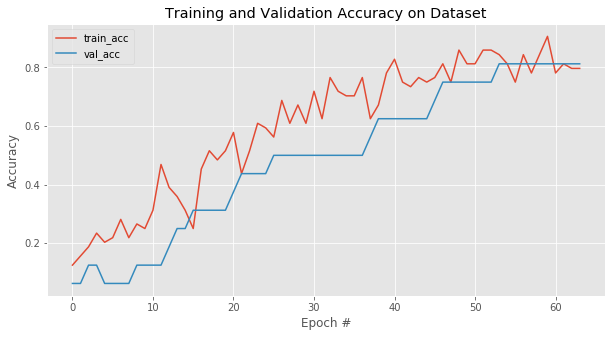

In [42]:
N = 64
plt.style.use("ggplot")
plt.figure(figsize=(10,5))

plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")

plt.title("Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="uppoer right")
plt.show()

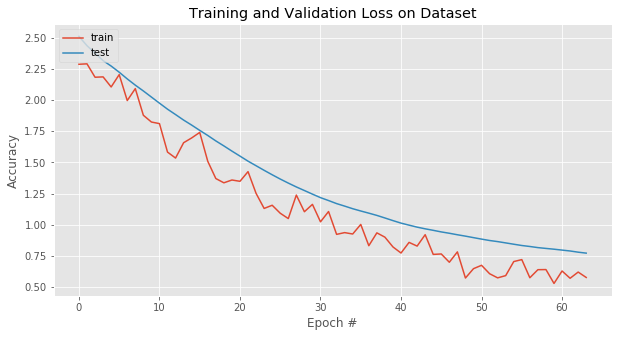

In [45]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")

plt.title('Training and Validation Loss on Dataset')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model evaluation

In [52]:
preds_vgg = model.predict(X_test)
preds_vgg.shape

(16, 8)

In [62]:
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(preds_vgg, axis=1))*100.)

81.25


## Save the weights of the fine-tuned VGG16 model

In [88]:
model.save_weights('model_weights/vgg_fine_tuned.h5')